# Project:India Conflict Project 

# Can we find out the patterns or factors behind the conflicts in India for the last 30 years? 

In [262]:
import pandas as pd
import numpy as np
import unidecode
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
from IPython.display import display # Allows the use of display() for DataFrames
import scipy
from scipy import stats
from scipy.stats import norm
#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler




## Data Extraction and Engineering

#### Data Selection 
1. Create data dictionaries 
2. Check data dictionaries
3. Correct CSV issues 
4. Load Event file based on event data dictionary
5. Load Static file based on static data dictionary
6. Load Temporal file based on temporal data dictionary
7. Get the unique list of GIDs from event data dictionary
8. Get the unique list of Years from event data dictionary
9. Filter Static and Temporal files based on the GIDs and Years   
10.Merge Event,Static and Temporal files 
11.Delete Duplicate ID files 

#### Data Validation
11.Check NaNs   
12.Check number of states    
13.Cross check Grid numbers    
14.Check death totals    

#### Data Correction   
15.Correct Data Issue ( E.g District)     

#### Engineer New Features     
16.Religious (Y/N)     
17.Language Based(Y/N)     
18.Region(S/W/NE/N)     

#### Exploratory Data Analysis     
1.Plot data      
2.Correlations      
3.Box plots     
4.Range/levels of values      
5.Unique values      



#### Feature Engineering
14.Check distributions for each data.     
16.Discuss an impute method for temporal variables and other missing variables[Impute methodology using linear regression]    
Discretize continuous features.     
Decompose features (e.g., categorical, date/time, etc.).     
Add promising transformations of features (e.g., log(x), sqrt(x), x2, etc.).     
Aggregate features into promising new features.     

#### Feature Selection 
16.Remove 'useless' high cardinality features     
17.Remove highly correlated features      

#### Feature Scaling 
Feature scaling: standardize or normalize features.    


#### Modeling 

Short List models 
Tuning of Hyper Parameters 
Pipe Line 
Evaluation parameters

#### Write-up 
Write-up
Format Code 
Modularity
Github 

In [271]:
#Get feature list from event,static and temporal dictionaries. We will use these lists to select the wanted features
#from the larger file
def create_data_dict():
    event_dict_df = pd.read_csv('final_raw_data/events_data_dict.csv')
    static_dict_df = pd.read_csv('final_raw_data/static_data_dict.csv',encoding = 'utf-8')
    temporal_dict_df = pd.read_csv('final_raw_data/temporal_data_dict.csv')
    event_features=list(event_dict_df.attribute.values)
    static_feature=list(static_dict_df.attribute.values)
    static_features=[]
    for each in static_feature:
        each= unidecode.unidecode(each)
        static_features.append(each.strip())
    temporal_features=list(temporal_dict_df.attribute.values)
    return event_features,static_features,temporal_features

In [272]:
def merge_files(event_features,static_features,temporal_features):
    events_df=pd.read_csv('final_raw_data/ged181.csv')
    static_df=pd.read_csv('final_raw_data/PRIO-GRID Static Variables.csv')
    temporal_df_1=pd.read_csv('final_raw_data/PRIO-GRID Yearly Variables_1.csv')
    temporal_df_2=pd.read_csv('final_raw_data/PRIO-GRID Yearly Variables_2.csv')
    temporal_df=pd.read_csv('final_raw_data/PRIO-GRID Yearly Variables.csv')
    temporal_df = pd.merge(temporal_df,temporal_df_1,on= ['gid','year'])
    temporal_df = pd.merge(temporal_df,temporal_df_2,on= ['gid','year'])
    events_df_reduced = events_df[event_features]
    static_df_reduced = static_df[static_features]
    temporal_df_reduced = temporal_df[temporal_features]

    temporal_df_reduced['year'] = pd.to_datetime(temporal_df_reduced['year'],format='%Y')
    temporal_df_reduced = temporal_df_reduced.set_index('year')
    temporal_df_reduced =temporal_df_reduced.interpolate(limit_direction='both')
    temporal_df_reduced = temporal_df_reduced.reset_index(drop=False)

    events_df_reduced['year'] = pd.to_datetime(events_df_reduced['year'],format='%Y')
    events_df_reduced.rename(columns={'priogrid_gid': 'gid'}, inplace=True)
    events_df_reduced_01= pd.merge(events_df_reduced,static_df_reduced,on= ['gid'],how='inner')
    events_df_reduced_02= pd.merge(events_df_reduced_01,temporal_df_reduced,on= ['gid','year'],how='inner')
    return events_df_reduced_02

In [273]:
def clean_data(events_df_reduced_02):
    events_df_reduced_02=events_df_reduced_02.loc[events_df_reduced_02['country'] == "India"]
    events_df_reduced_02.adm_1 = events_df_reduced_02.adm_1.replace('Arunachal Pradesh', 'Arunachal Pradesh State')
    events_df_reduced_02.adm_1 = events_df_reduced_02.adm_1.replace('Union Territory of Chandigarh', 'Chandigarh Union Territory')
    events_df_reduced_02.adm_1 = events_df_reduced_02.adm_1.replace('Odisha State', 'Orissa State')
    events_df_reduced_02.adm_2=events_df_reduced_02.adm_2.str.title()
    events_df_reduced_02['year'] = events_df_reduced_02['year'].dt.year
    return events_df_reduced_02

In [274]:
def find_missing(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (df.shape[0] 
                                    - missing_df['missing_count']) / df.shape[0] * 100
    missing_df=missing_df.sort_values('filling_factor').reset_index(drop = True)
    return missing_df

In [275]:
def shape_data(events_df_reduced_02):
    state_list=['Jammu and Kashmir State','Assam State','Manipur State','Tripura State','Nagaland State','Meghalaya State','Arunachal Pradesh State','Mizoram State','Punjab State']
    left_extremism_list=['CPI-ML-VM ','PWG','CPI-ML-J','CPI-Maoist','MCC','CPI-ML-VM','PLFI ','PCPA','PLFI']
    separatism_list=['ULFA','Sikh insurgents','Kashmir insurgents','Government of Pakistan','NDFB','NSCN-IM']
    events_df_reduced_02['separatism?']=np.where(((events_df_reduced_02['adm_1'].isin (state_list)) | events_df_reduced_02['side_a'].isin (separatism_list) | events_df_reduced_02['side_b'].isin(separatism_list)) & ~events_df_reduced_02['conflict_name'].isin(['Hindus (India) - Muslims (India)']),1,0)
    events_df_reduced_02['left_extermism?']=np.where((events_df_reduced_02['side_a'].isin (left_extremism_list) | events_df_reduced_02['side_b'].isin(left_extremism_list)),1,0)
    events_df_reduced_02['death_final']=np.where((events_df_reduced_02['best']>=events_df_reduced_02['high']),events_df_reduced_02['best'],events_df_reduced_02['high'])
    high_cardinal=['conflict_new_id','conflict_name','dyad_new_id','dyad_name','side_a_new_id','gwnoa','side_a','side_b_new_id','side_b','gwnob','where_coordinates','country','adm_1','adm_2','date_start','date_end','deaths_a','deaths_b','deaths_civilians','best','high','geom_wkt','gwno','imr_mean']
    events_df_reduced_02=events_df_reduced_02.drop(high_cardinal, axis=1)
    return events_df_reduced_02

In [276]:
def check_corre(events_df_reduced_02):
    ext_data = events_df_reduced_02[:]
    ext_data_corrs = ext_data.corr()
    plt.figure(figsize = (20, 15))
    # Heatmap of correlations
    sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
    plt.title('Correlation Heatmap');

In [277]:
def remove_corr(events_df_reduced_02,high_corr):
    events_df_reduced_02=events_df_reduced_02.drop(high_corr, axis=1)
    return events_df_reduced_02
    

In [278]:
def scale_encode(events_df_reduced_02,numeric_names,cat_column_names):
    events_df_reduced_02=pd.get_dummies(data=events_df_reduced_02, columns=cat_column_names)
    #events_df_reduced_02['death_final'] = np.log(events_df_reduced_02['death_final'])
    #scaler = preprocessing.StandardScaler()
    #events_df_reduced_02[numeric_names] = scaler.fit_transform(events_df_reduced_02[numeric_names])
    
    #events_df_reduced_02['death_final'] = np.log(events_df_reduced_02['death_final'])
    #sns.distplot(events_df_reduced_02['death_final'],fit=norm);
    #fig = plt.figure()
    #res = stats.probplot(events_df_reduced_02['death_final'], plot=plt)
    return events_df_reduced_02

In [325]:
def model_short(x_train,y_train,x_test,y_test,feature_list):
#    models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(),GradientBoostingRegressor()]
#    model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor','Gradientboosting Regressor']
    models=[RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor()]
    model_names=['RandomForestRegressor','AdaBoostRegressor','Gradientboosting Regressor']
    mae=[]
    d={}
    for model in range (len(models)):
        clf=models[model]
        print(model_names[model])
        clf.fit(x_train,y_train)
        test_pred=clf.predict(x_test)
        importances = clf.feature_importances_
# Extract the feature importances into a dataframe
        feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
# Show the top 10 most important
        feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
        print(feature_results.head(10))
        mae.append(np.mean(abs(y_test - test_pred)))
    d={'Modelling Algo':model_names,'MAE':mae} 
    return d
    

In [280]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [330]:
event_features,static_features,temporal_features=create_data_dict()
events_df_reduced_02=merge_files(event_features,static_features,temporal_features)
events_df_reduced_02=clean_data(events_df_reduced_02)



/Users/sandeepnair/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/sandeepnair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sandeepnair/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/sandeepnair/anaconda3/lib/python3.7/site-packages/pandas/core/

# Data Analysis

In [333]:
events_df_reduced_02['high'].describe()

count    13724.000000
mean         4.904547
std         45.163670
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       3226.000000
Name: high, dtype: float64

In [364]:
events_df_reduced_02.shape

(13724, 44)

##### Death counts are varied a lot . Probably this is going to affect our modelling 

In [334]:
events_df_reduced_02['active_year'].value_counts()

1    12659
0     1065
Name: active_year, dtype: int64

##### Value '1' means this is an ongoing conflcit . So as you can see majority of the conflicts are on going

In [335]:
events_df_reduced_02.dtypes.value_counts()

float64    19
int64      13
object     12
dtype: int64

##### Checking the data type counts

In [339]:
states1 = events_df_reduced_02.groupby('adm_1').size().sort_values(ascending=False)
states1.head(10)

adm_1
Jammu and Kashmir State    7272
Assam State                1496
Chhattisgarh State          674
Manipur State               595
Andhra Pradesh State        504
Jharkhand State             485
Tripura State               410
Punjab State                375
West Bengal State           316
Orissa State                314
dtype: int64

##### India's top 10 affected states

In [345]:

grid_id_list=list(events_df_reduced_02.gid.unique())
year_list=list(events_df_reduced_02.year.unique())


print('Total number of unique grids  %f' % len(grid_id_list))
print('Total years repesented %f' % len(year_list))

Total number of unique grids  438.000000
Total years repesented 26.000000


##### Total number of unique grids  438
##### Total years repesented 26

In [349]:
after = events_df_reduced_02.groupby('dyad_name').size().sort_values(ascending=False)
after.head(10)

dyad_name
Government of India - Kashmir insurgents        5579
Kashmir insurgents - Civilians                  1520
Government of India - CPI-Maoist                1161
CPI-Maoist - Civilians                          1101
Government of India - ULFA                       524
Government of India - PWG                        261
Sikh insurgents - Civilians                      227
Government of India - Government of Pakistan     223
Government of India - Sikh insurgents            214
ULFA - Civilians                                 201
dtype: int64

##### Top reasons for conflicts 

In [351]:

after = events_df_reduced_02.groupby('year').size().sort_values(ascending=False)
after.head(10)


year
2000    1287
2002    1010
2006     932
2005     911
2009     845
2010     784
2004     764
2003     744
2007     726
2008     673
dtype: int64

##### Most violent years 

In [352]:

after = events_df_reduced_02.groupby('side_a').size().sort_values(ascending=False)
after.head(10)



side_a
Government of India    9352
Kashmir insurgents     1520
CPI-Maoist             1101
NSCN-IM                 232
Sikh insurgents         227
ULFA                    201
Hindus (India)          185
NLFT                    132
NDFB                    119
ATTF                     61
dtype: int64

##### This is curious because Government of India is shown as the instigator in most of the cases . But after reading the code book I have realized that when ever government is involved in a conflict it is automatically considers as side_a whether state instigated or intiated the violence or not

In [357]:
kashmir_df=events_df_reduced_02[events_df_reduced_02['adm_1'].isin(['Jammu and Kashmir State'])]

kashmir_df.groupby('year').size().sort_values(ascending=False)

year
2000    1002
2002     785
2005     696
2004     563
2006     478
2003     465
1999     410
2007     247
2010     233
2009     231
2001     228
1998     216
2008     211
1993     210
1994     185
1995     176
1997     154
1990     132
2014     126
2011     114
2013      88
2012      87
1996      77
1991      76
1992      70
1989      12
dtype: int64

##### 2000 was the most violent year in Kashmir

In [360]:
kashmir_df_aggr=kashmir_df.groupby('adm_2').size()
top_affected_kashmir_distr= kashmir_df_aggr[kashmir_df_aggr>1].sort_values(ascending=False)
print(top_affected_kashmir_distr.head(5))

adm_2
Baramulla District    976
Kupwara District      928
Srinagar District     720
Anantnag District     613
Poonch District       574
dtype: int64


##### Top 5 affected districts in Kashmir

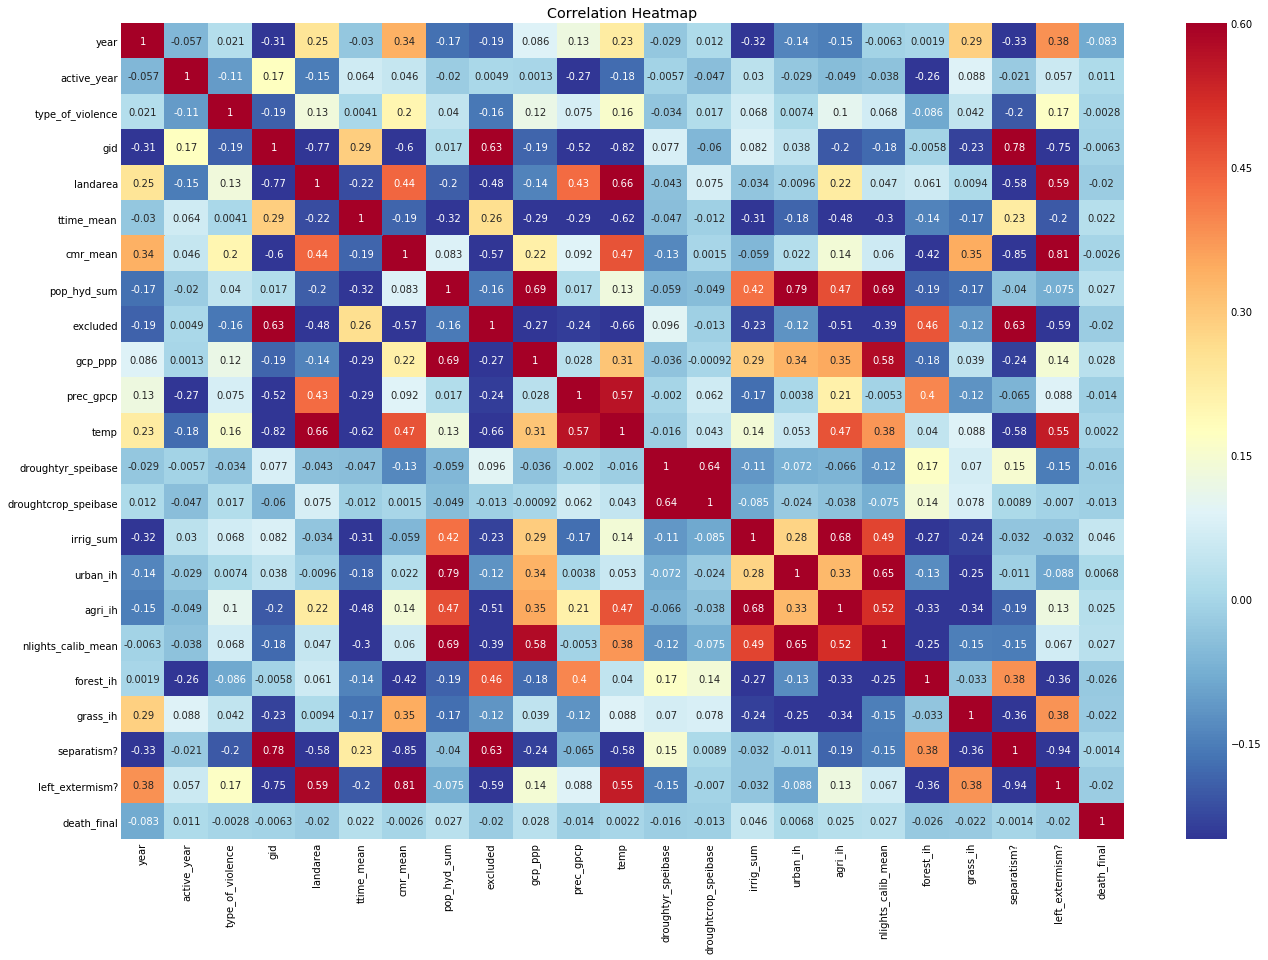

In [282]:
events_df_reduced_02=shape_data(events_df_reduced_02)
check_corre(events_df_reduced_02)



##### gid , cmr_mean, pop_hyd_sum,agri_ih,separatism? are highly correlated and can be removed 

In [283]:
cat_column_names=['type_of_violence','left_extermism?','active_year']
events_df_reduced_02[cat_column_names].nunique().sort_values(ascending=True)

left_extermism?     2
active_year         2
type_of_violence    3
dtype: int64

##### Checking the level of the categorical columns 

In [284]:
high_corr=['gid','cmr_mean','pop_hyd_sum','agri_ih','separatism?']
events_df_reduced_02=remove_corr(events_df_reduced_02,high_corr)


In [285]:
numeric_names=['year','landarea','ttime_mean','excluded','gcp_ppp','prec_gpcp','temp','droughtyr_speibase','droughtcrop_speibase','irrig_sum','urban_ih','nlights_calib_mean','forest_ih','grass_ih','death_final']

In [286]:
events_df_reduced_02=scale_encode(events_df_reduced_02,numeric_names,cat_column_names)

In [287]:
find_missing(events_df_reduced_02)  

,column_name,missing_count,filling_factor
0,year,0,100.0
1,left_extermism?_1,0,100.0
2,left_extermism?_0,0,100.0
3,type_of_violence_3,0,100.0
4,type_of_violence_2,0,100.0
5,type_of_violence_1,0,100.0
6,death_final,0,100.0
7,grass_ih,0,100.0
8,forest_ih,0,100.0
9,nlights_calib_mean,0,100.0


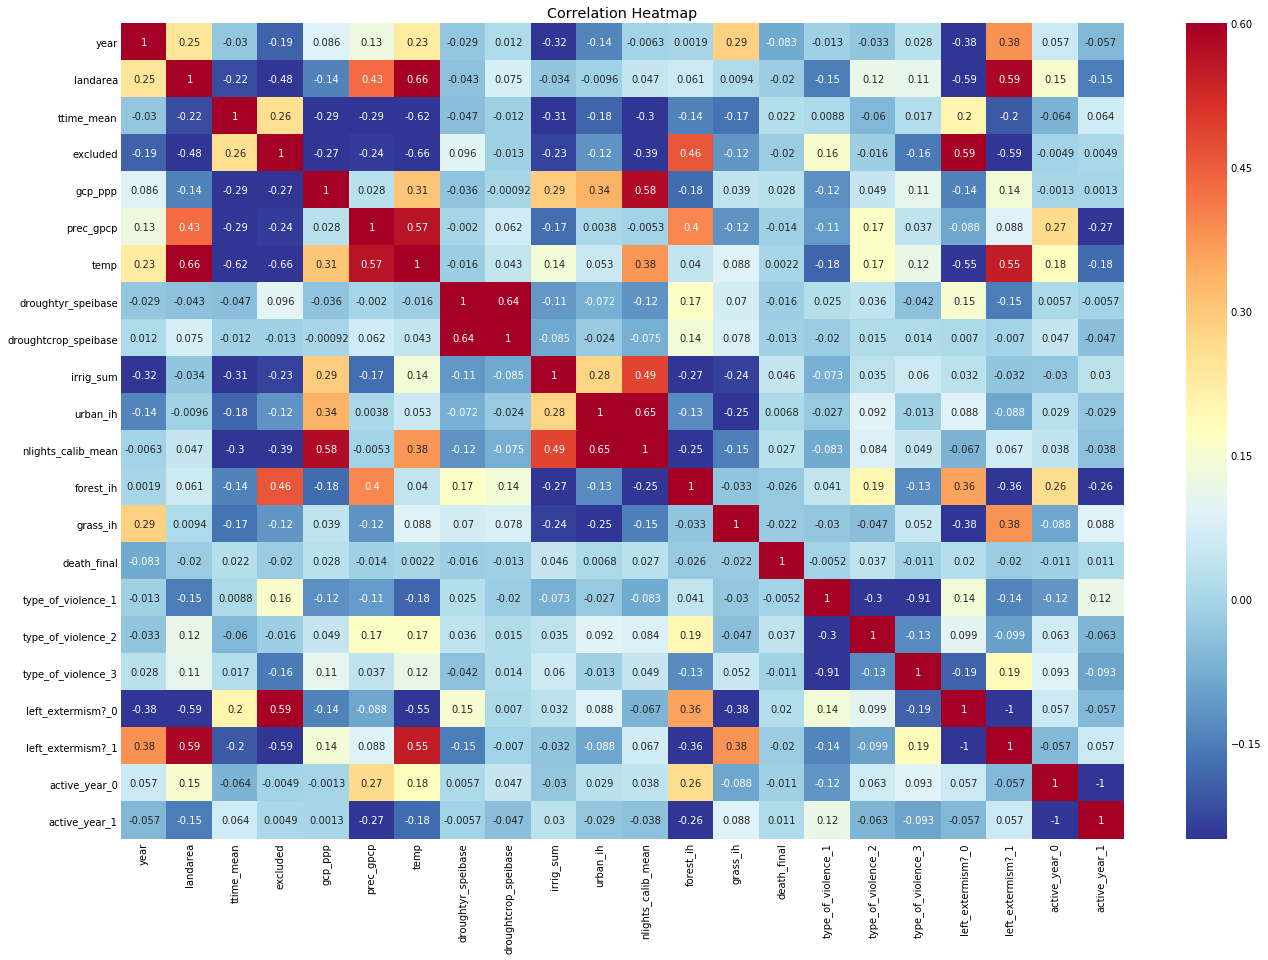

In [255]:
check_corre(events_df_reduced_02)

#### Split test and training data to a 70 and 30 split

In [288]:
x_train,x_test,y_train,y_test=train_test_split(events_df_reduced_02.drop('death_final',axis=1),events_df_reduced_02['death_final'],test_size=0.25,random_state=42)

#### Use MinMax scaler to scale the features 

In [289]:

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(x_train)
# Transform both the training and testing data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### Establish a base line performance

In [291]:

baseline_guess = np.median(y_train)
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 2.00
Baseline Performance on the test set: MAE = 4.6129


In [312]:
# train_features is the dataframe of training features
feature_df = events_df_reduced_02.loc[:, events_df_reduced_02.columns != 'death_final']
feature_list = list(feature_df.columns)



In [326]:
model_short(x_train,y_train,x_test,y_test,feature_list)

RandomForestRegressor
              feature  importance
0           irrig_sum    0.170512
1                temp    0.159519
2  type_of_violence_2    0.138782
3           prec_gpcp    0.119218
4                year    0.071656
5  type_of_violence_3    0.070896
6            grass_ih    0.060502
7             gcp_ppp    0.048135
8  type_of_violence_1    0.046222
9            landarea    0.034021
AdaBoostRegressor
              feature  importance
0           irrig_sum    0.505252
1                temp    0.162424
2                year    0.114671
3  type_of_violence_3    0.096141
4  type_of_violence_1    0.048471
5            grass_ih    0.047971
6             gcp_ppp    0.022070
7  nlights_calib_mean    0.001870
8            landarea    0.000645
9       active_year_1    0.000485
Gradientboosting Regressor
              feature  importance
0                temp    0.223631
1           irrig_sum    0.169791
2             gcp_ppp    0.099942
3                year    0.097454
4  type_of_viol

{'Modelling Algo': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'Gradientboosting Regressor'],
 'MAE': [5.777955537920489, 7.170684436745401, 5.650756962655786]}

In [361]:

# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

scorer = make_scorer(mean_absolute_error) 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation

random_cv_gb = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                              cv=4, n_iter=25, 
                               scoring = scorer,
                               n_jobs = -1, verbose = 1, 
                               random_state=42)



# Fit on the training data
random_cv_gb.fit(x_train, y_train) 

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.0min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          scoring=make_scorer(mean_absolute_error), verbose=1)

In [362]:
random_cv.best_params_

{'gamma': 0.001, 'C': 0.001}

In [363]:
best_model=GradientBoostingRegressor(n_estimators= 500,
 min_samples_split= 6,
 min_samples_leaf= 1,
 max_features='auto',
 max_depth= 15,
 loss= 'huber')

predictions = random_cv.predict(x_test)

# Evaluate the model
mae = np.mean(abs(predictions - y_test))

print('Gradient Boosted Performance on the test set: MAE = %0.4f' % mae)

Gradient Boosted Performance on the test set: MAE = 5.1410


### Conclusion and Analysis
There are certain features which are consistently prominent in all the three models which we have tried. Those are 
irrig_sum,temp,type_of_violence,prec_gpcp,grass_ih,landarea,gcp_ppp.


What are these variables? Lets look deeper.

*irrig_sum* gives the total area (in hectares) equipped for irrigation within the grid cell.

*temp*- gives the yearly mean temperature (in degrees Celsius) in the cell, based on monthly meteorological statistics from GHCN/CAMS, developed at the Climate Prediction Center, NOAA/National Weather Service. This indicator contains data for the years 1948-2014.

*Type of violence*

1: state-based conflict
2: non-state conflict
3:one-sided violence

*prec_gpcp* gives the yearly total amount of precipitation (in millimeter) in the cell, based on monthly meteorological statistics from the GPCP v.2.2 Combined Precipitation Data 

*grass_ih* gives the percentage area of the cell covered by grasslands

*landarea* gives the total area covered by land in the grid cell in square kilometers as defined by the CShapes dataset

*gcp_ppp* indicates the gross cell product, measured in USD using purchasing-power-parity, based on the G-Econ dataset v4.0, last modified May 2011. 

What does this mean?

It shows promoising insights that socio, economical and geographical features can be used to describe the level of fatality in an area . What is more interesting is that many predictor variables come in the category of temporal variables which means that it is changing with time. So we can look further whether industrialization(less grass lands) or high economic growth correlates to the number and intensity  of the conflicts.

#### Further improvement suggestions 

We need to take other features present in the PRIO GRID file and try to repeat the study. We need to focus mainly on the geo , spatial variables to see how the intensity and scale correlates with the new features.


That is very computational challenging to do as a personal project. Both Uppasala university and Peace research has sophisticated computing clusters to do the modelling
